In [93]:
# equilibrage des classes
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTE

# librairies générales
from collections import Counter
import functions as fct
import warnings
from joblib import dump, load
import timeit
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
# from sklearn.calibration import calibration_curve, CalibratedClassifierCV


from scipy.stats import randint
from scipy.stats import uniform

In [94]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


  # Import des données

In [95]:
data = pd.read_csv("../01_DATA/data_for_modelling.csv")
liste_quali = pd.read_csv("../01_DATA/liste_quali.csv")
prev_app = pd.read_csv('../01_DATA/previous_application.csv')
print(data.shape)
print(liste_quali.shape)


(307177, 24)
(2, 2)


In [96]:


def load_joblibs(job_dir):
    """Permet de charger les encodeurs et les imputeurs depuis le dossier en argument"""
    mean_imputer = load(job_dir+'/mean_imputer.joblib')
    regexp = 'label_encoder-'
    label_encoders = {}
    for file_name in os.listdir(os.getcwd()+'/joblib'):
        if re.match(regexp, file_name):
            feature = file_name.split('-')[1].split('.')[0]
            label_encoders[feature] = load(job_dir+'/'+file_name)
    return label_encoders, mean_imputer



In [97]:
label_encoders, mean_imputer = load_joblibs('./joblib')


 # Data pour test rapide

In [43]:
# data = data.sample(frac=0.1)


 # Préparation des données

In [44]:
# mise en forme liste variables qualitatives
# retrait colonne 'unnamed'
liste_quali.drop(columns=['Unnamed: 0'], inplace=True)
# transformation en liste et retrait de la variable 'target'
liste_quali = liste_quali['0'].tolist()


In [45]:
# l'index des lignes correspond à l'ID de la demande de prêt en cours
data = data.set_index('SK_ID_CURR')

# Séparation de la target des données d'apprentissage
target = data.TARGET
data = data.drop(columns=['TARGET'], axis=1)
data[liste_quali] = data[liste_quali].astype('object')


In [46]:
# séparation des données en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(
    data, target, train_size=0.8, random_state=0)
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train : (24574, 22)
y_train : (24574,)
X_test : (6144, 22)
y_test : (6144,)


In [47]:
print("Notre échantillon d'entraînement contient %d individus avec %d variables" %
      (X_train.shape[0], X_train.shape[1]))


Notre échantillon d'entraînement contient 24574 individus avec 22 variables


 # Preprocessing

In [48]:
# # mise en place du pipeline pour les données qualitatives
# quali_pipeline = make_pipeline(LabelEncoder())

# mise en place du pipeline pour les données quantitatives
quanti_pipeline = make_pipeline(StandardScaler())
liste_quanti = [
    feature for feature in data.columns if feature not in liste_quali]

# mise en place du preprocessor
preprocessor = make_column_transformer((quanti_pipeline, liste_quanti))
# (quali_pipeline, liste_quali))


In [49]:
# quali_pipeline


In [50]:
# type(liste_quanti)


In [51]:
set_config(display='diagram')
preprocessor


ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                  'DAYS_ID_PUBLISH',
                                  'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2',
                                  'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
                                  'BUREAU_DAYS_CREDIT_MEAN',
                                  'BUREAU_DAYS_CREDIT_UPDATE_MEAN',
                                  'BUREAU_CREDIT_ACTIVE_Closed_MEAN',
                                  'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
                                  'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
                                  'PREV_CODE_REJECT_REASON_HC_MEAN',
                                  'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
                                  'PREV_NAME_GOODS_CATEGORY_House '
                                  'Construction_MEAN',
                                  'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
                                  'APPROVED_DAYS_DECISION_MIN'])])

In [52]:
y_train.value_counts()


0.0    22572
1.0     2002
Name: TARGET, dtype: int64

 # Equilibrage des classes
 la target est déséquilibrée (92% de prêts accordés) => il faut donc rééquilibrer les classes pour ne pas fausser l'apprentissage du modèle.

 Plusieurs options existent :
 - sampling aléatoire dans la classe sur-représentée de façon à arriver à 50-50.
     * ++ = très simple à mettre en place
     * -- = va conduire à un petit jeu d'entrainement : 39 370 individus contre 243 612 actuellement
 - génération d'individus fictifs à partir des données de la classe sous-représentée (SMOTE)
     * ++ = permet d'avoir un jeu de donnée plus grand
     * -- = il n'est pas recommandé de générer + de 25% de 'fausses' données
 - combinaison des deux méthodes précédentes
     * ++ : permet de limiter les risques de SMOTE tout en augmentant la taille du jeu d'entrainement
 - utilisation de class_weight quand cette option est disponible dans les modèles
     * ++ : très simple d'utilisation
     * -- : ne va pas compenser le manque d'information potentiel de la classe sous-représentée

 ## Equilibrage via SMOTE + under sampling

In [53]:
counter_init = Counter(y_train)
print(counter_init)
ratio = counter_init[1]/counter_init[0]
print("ratio initial 1/0 : {:.3f}".format(ratio))


Counter({0.0: 22572, 1.0: 2002})
ratio initial 1/0 : 0.089


 - SMOTE : Si on se fixe comme limite de ne générer que 25% de données en plus dans la classe minoritaire via SMOTE, cela revient à se fixer une sampling_strategy de 0.087*1.25 = 0.11
 - Under-sampling : l'objectif est d'arriver à 50-50 dans la répartition des classes, sampling_strategy = 1

In [54]:
oversampling = SMOTENC(sampling_strategy=.11, categorical_features=[0, 8])
undersampling = RandomUnderSampler(sampling_strategy=1)

steps = [('over', oversampling), ('under', undersampling)]
pipeline_balanced = Pipeline(steps=steps)

X_train_balanced, y_train_balanced = pipeline_balanced.fit_resample(
    X_train, y_train)

counter_balanced = Counter(y_train_balanced)
print(counter_balanced)
print(len(y_train_balanced))
ratio = counter_balanced[1]/counter_balanced[0]
print('ratio SMOTE : {:.3f}'.format(counter_balanced[1] / counter_init[0]))
print("ratio final 1/0 : {:.3f}".format(ratio))


Counter({0.0: 2482, 1.0: 2482})
4964
ratio SMOTE : 0.110
ratio final 1/0 : 1.000


In [55]:
delta_1 = counter_balanced[1] - counter_init[1]
print("création de {} individus (+{:.2f} % par rapport au jeu de données initial) pour la classe sous-représentée".format(delta_1, 100*delta_1/len(y_train)))
print("sous-échantillonnage de {} individus ({:.2f} %) appartenant à la classe majoritaire".format(
    counter_balanced[0], 100*counter_balanced[0]/counter_init[0]))
print("le jeu de données est désormais réparti à {:.2f} %".format(100*counter_balanced[0]/len(y_train_balanced)),
      "pour la classe majoritaire et {:.2f} % pour la classe minoritaire".format(100*counter_balanced[1]/len(y_train_balanced)))


création de 480 individus (+1.95 % par rapport au jeu de données initial) pour la classe sous-représentée
sous-échantillonnage de 2482 individus (11.00 %) appartenant à la classe majoritaire
le jeu de données est désormais réparti à 50.00 % pour la classe majoritaire et 50.00 % pour la classe minoritaire


 ## Equilibrage via class_weight
 calcul du poids à attribuer aux catégories

In [56]:
# count: Dictionnaire contant le nombre de cas positifs et le nombre de cas négatifs
count = Counter(y_train)
# weight_positive: Poids à accorder aux cas positifs
weight_positive = count[0]/count[1]
print("Il y à %.2f cas positifs pour 1 cas négatif" % weight_positive)
weight_positive = int(round(weight_positive))


Il y à 11.27 cas positifs pour 1 cas négatif


 # FONCTIONS

In [57]:


def affichage_resultats(model, run, X_train, y_train, X_test, y_test, resultats, pourcent_matrice_conf=False):
    start = timeit.default_timer()
    # entrainement du modèle
    model.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model.predict(X_test)
    # extraction des probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_pourcent = 100 * conf_mat / len(y_test)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=12)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))

    nom_run = run + "_" + str(model[1])

    # Stockage des résultats
    resultats.loc[nom_run, "AUC"] = auc_score
    resultats.loc[nom_run, "Recall"] = recall
    resultats.loc[nom_run, 'Precision'] = precision
    resultats.loc[nom_run, "F1"] = f1
    resultats.loc[nom_run, "Fbeta"] = fbeta
    resultats.loc[nom_run, "seuil_opt"] = best_thresh
    resultats.loc[nom_run, "durée_calculs_s"] = elapsed

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title(
        "Receiver Operating Characteristic\nmodel : {}\n".format(model[1]))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    if pourcent_matrice_conf:
        sns.heatmap(conf_mat_pourcent, annot=True, cmap=my_cmap)
        plt.title("Matrice de confusion exprimée en % du\nnombre "
                  "total de candidats au crédit\n\n1 = refus du crédit\n0 = acceptation du crédit\n")
    else:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
        plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
            nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats



 # Metrique metier
 Dans notre situation deux types d'erreurs sont possibles :
 - accorder un prêt à un individu qui ne le remboursera pas (erreur de type II) => risque de perte d'argent +++ pour la banque
 - refuser un prêt à un individu qui aurait pu le rembourser (erreur de type I) => risque de gain moins important pour la banque

 La première erreur se mesure avec le recall (taux de vrais positifs) et la deuxième avec la précision (proportion de prédictions correctes parmis les points prédits +)

 Calculons dans un premier temps les caractéristiques d'un prêt moyen sur la base des précédentes demandes de prêt accordés (table previous_application), ce qui permettra de quantifier combien fait perdre une erreur de type II et quel gain n'est pas fait par une erreur de type I.

 *Je fais l'hypothèse (pessimiste) que lorsqu'il y a un défaut de paiement l'intégralité du prêt n'est pas remboursé*


In [58]:
def mensualite(duree, montant, taux):
    '''
    duree : en années
    montant : montant total du pret accordé
    taux : taux d'interet du prêt
    '''
    m = montant * (taux/12) / (1 - (1 + taux/12)**(-12*duree))
    return m



In [59]:
# Days 365.243 values -> nan
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)


In [60]:
filtre_approved = prev_app.NAME_CONTRACT_STATUS == 'Approved'

taux_moyen = prev_app[filtre_approved].RATE_INTEREST_PRIMARY.mean()
montant_moyen = prev_app[filtre_approved].AMT_CREDIT.mean()
duree_moyenne_jours = (- (prev_app[filtre_approved].DAYS_DECISION -
                       prev_app[filtre_approved].DAYS_TERMINATION)).mean()
duree_moyenne_ans = duree_moyenne_jours / 365.25

mensualite_moyenne = mensualite(
    duree=duree_moyenne_ans, montant=montant_moyen, taux=taux_moyen)
gain_si_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne - montant_moyen
perte_si_non_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne
ratio_perte_gain = perte_si_non_rembourse / gain_si_rembourse

print('taux_moyen : {:.3f}'.format(taux_moyen))
print('montant moyen : {:.2f}'.format(montant_moyen))
print('durée moyenne (ans): {:.2f}'.format(duree_moyenne_ans))
print('mensualite moyenne : {:.0f}'.format(mensualite_moyenne))
print('-'*10)
print('gain si pret remboursé : {:.0f}'.format(gain_si_rembourse))
print('perte si pret non remboursé : {:.0f}'.format(perte_si_non_rembourse))
print('ratio perte/gain : {:.2f}'.format(ratio_perte_gain))



taux_moyen : 0.188
montant moyen : 202564.18
durée moyenne (ans): 0.84
mensualite moyenne : 21837
----------
gain si pret remboursé : 18070
perte si pret non remboursé : 220634
ratio perte/gain : 12.21


In [61]:
print("Le coût d'un défaut de paiement (erreur de type II) représente {:.0f} fois le gain non réalisé par une erreur de type I".format(
    ratio_perte_gain))


Le coût d'un défaut de paiement (erreur de type II) représente 12 fois le gain non réalisé par une erreur de type I


 Il s'agit donc bien de maximiser le recall et la précision, en accordant plus d'importance au recall qui permet de minimiser les faux négatifs qui coutent très chers à la banque. La metrique F-Beta permet d'attribuer un poids plus grand au recall via le choix du paramètre Beta et ainsi maximiser le nombre de vrais positifs tout en minimisant les faux negatifs et les faux positifs.

 Le paramètre Beta est donx fixé à 12 de façon à favoriser la maximisation du recall et ainsi éviter au maximum les erreurs de type II.

 # Selection du modèle
 ## Dummy_classifier

In [62]:
resultats_choix_model = pd.DataFrame(
    columns=["AUC", "Recall", "Precision", "F1", "Fbeta", "seuil_opt", "durée_calculs_s"])


Seuil optimal de discrimination:1.081

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.46      0.50      0.48      6144
weighted avg       0.85      0.92      0.89      6144

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500


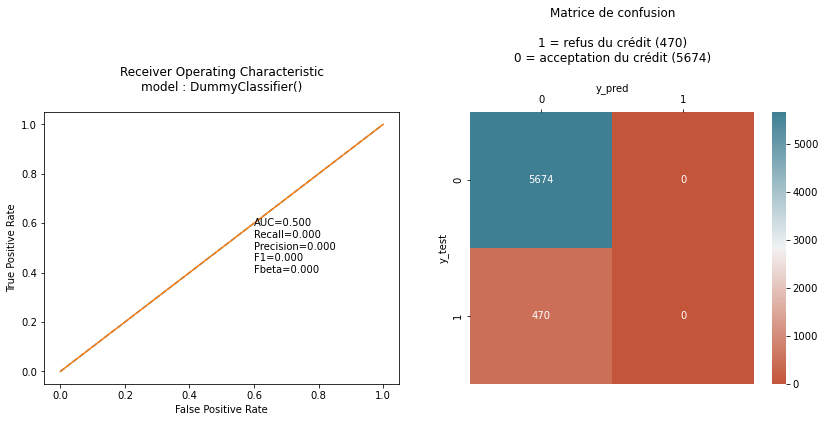

In [63]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)
resultats_choix_model = affichage_resultats(
    model, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


Seuil optimal de discrimination:1.500

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.46      0.50      0.48      6144
weighted avg       0.85      0.92      0.89      6144

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500


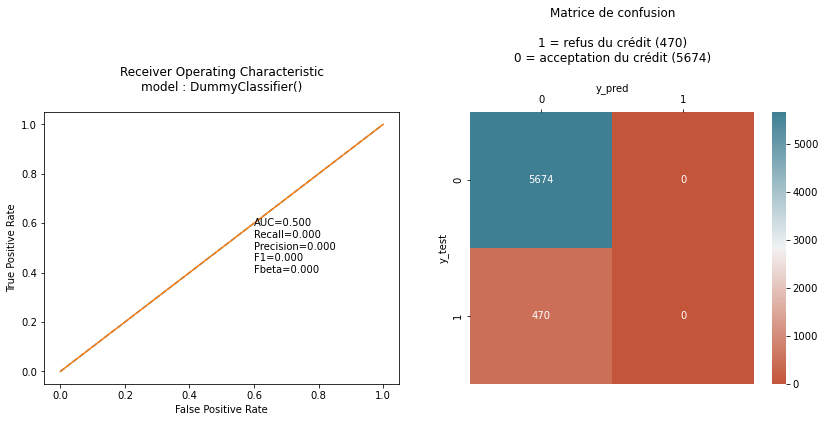

In [64]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


Seuil optimal de discrimination:1.081

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.46      0.50      0.48      6144
weighted avg       0.85      0.92      0.89      6144

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500


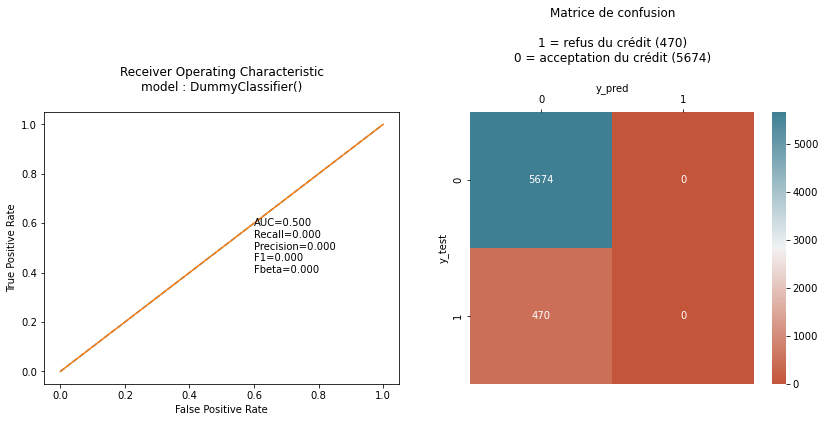

In [65]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [66]:
resultats_choix_model


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.081468,0.012853
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.5,0.006222
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.081468,0.01451


 ## Regression logistique
 comme la feature selection a écarté les variables redondantes, il n'est pas nécessaire de mettre en place une régularisation dans le cadre de la regression logistique
 ### jeu de données non équilibré

Seuil optimal de discrimination:0.082

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.45      0.01      0.02       470

    accuracy                           0.92      6144
   macro avg       0.69      0.50      0.49      6144
weighted avg       0.89      0.92      0.89      6144

----------
f1-score : 0.021
fbeta-score : 0.011
precision : 0.455
recall : 0.011
auc : 0.698


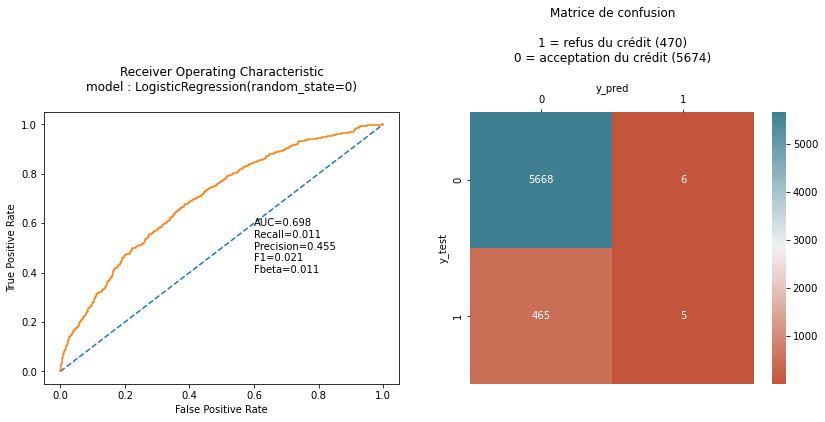

In [67]:

model = LogisticRegression(random_state=0)
lr = make_pipeline(preprocessor, model)
# lr.fit(X_train, y_train)

resultats_choix_model = affichage_resultats(
    lr, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### jeu de données équilibré (smote + undersampling)

Seuil optimal de discrimination:0.539

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      5674
         1.0       0.13      0.59      0.22       470

    accuracy                           0.68      6144
   macro avg       0.54      0.64      0.51      6144
weighted avg       0.89      0.68      0.75      6144

----------
f1-score : 0.219
fbeta-score : 0.576
precision : 0.134
recall : 0.589
auc : 0.697


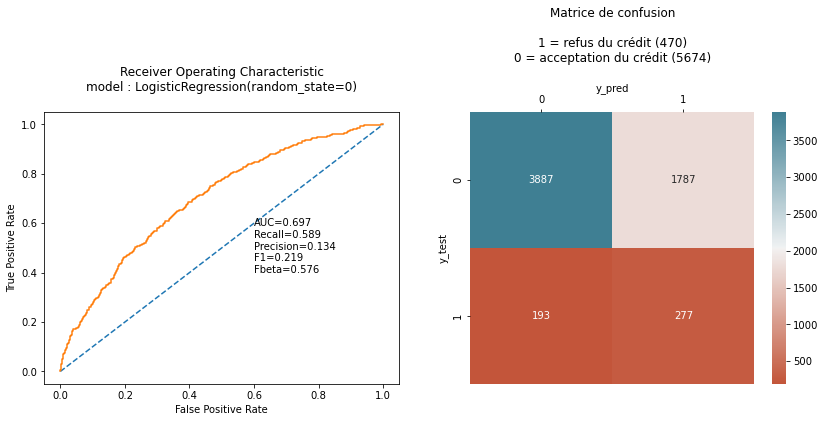

In [68]:
model = LogisticRegression(random_state=0)
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.489

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      5674
         1.0       0.13      0.58      0.22       470

    accuracy                           0.68      6144
   macro avg       0.54      0.64      0.51      6144
weighted avg       0.89      0.68      0.76      6144

----------
f1-score : 0.219
fbeta-score : 0.566
precision : 0.135
recall : 0.579
auc : 0.697


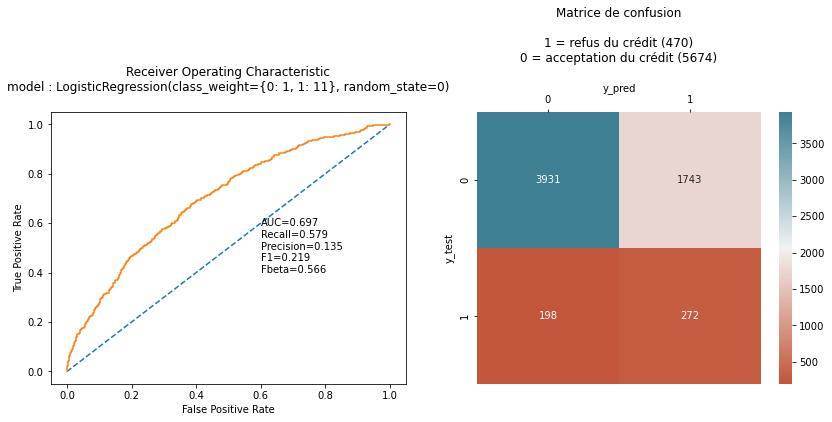

In [69]:
model = LogisticRegression(random_state=0, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [70]:
resultats_choix_model


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.081468,0.012853
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.5,0.006222
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.081468,0.01451
not_balanced_LogisticRegression(random_state=0),0.698185,0.010638,0.454545,0.02079,0.01071,0.082049,0.041515
balanced_SMOTE_LogisticRegression(random_state=0),0.697315,0.589362,0.134205,0.218627,0.575892,0.539161,0.013985
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=0)",0.696831,0.578723,0.134988,0.218913,0.565894,0.488799,0.041447


 # SGD Classifier
 ## jeu de données non équilibré

Seuil optimal de discrimination:0.013

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.46      0.50      0.48      6144
weighted avg       0.85      0.92      0.89      6144

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.601


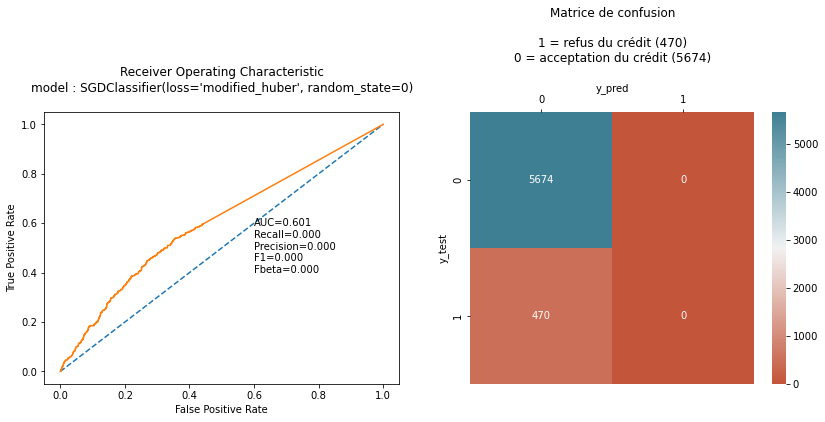

In [71]:

model = SGDClassifier(random_state=0, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.332

              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      5674
         1.0       0.13      0.47      0.20       470

    accuracy                           0.71      6144
   macro avg       0.53      0.60      0.51      6144
weighted avg       0.88      0.71      0.78      6144

----------
f1-score : 0.199
fbeta-score : 0.462
precision : 0.126
recall : 0.470
auc : 0.629


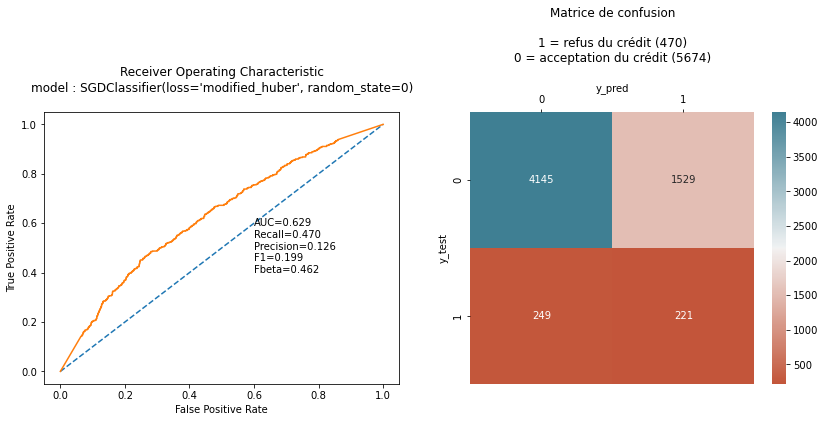

In [72]:
model = SGDClassifier(random_state=0, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ## Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.013

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.46      0.50      0.48      6144
weighted avg       0.85      0.92      0.89      6144

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.601


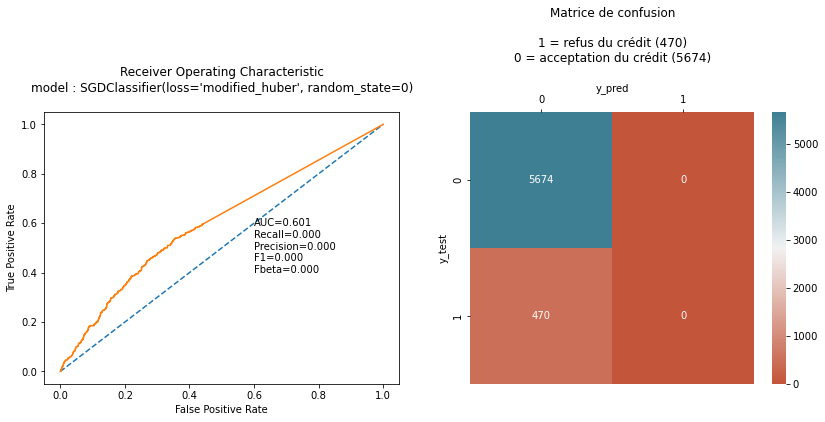

In [73]:
model = SGDClassifier(random_state=0, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## Random Forest
 ### Jeu de données non équilibré

Seuil optimal de discrimination:0.470

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.20      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.56      0.50      0.48      6144
weighted avg       0.87      0.92      0.89      6144

----------
f1-score : 0.004
fbeta-score : 0.002
precision : 0.200
recall : 0.002
auc : 0.667


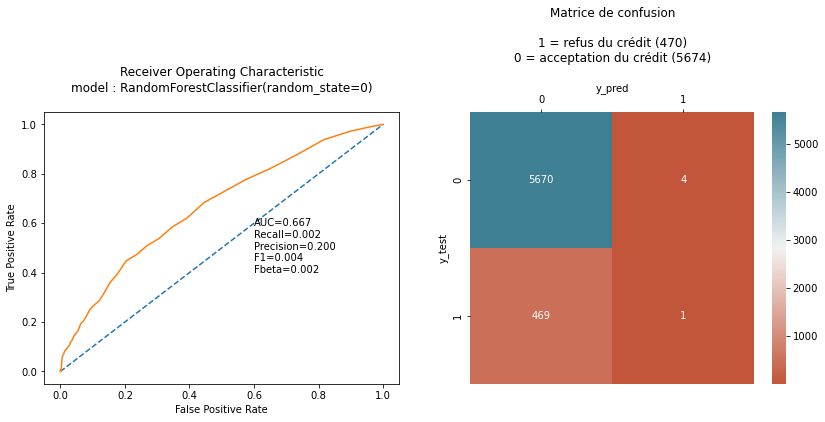

In [74]:

model = RandomForestClassifier(random_state=0)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.590

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81      5674
         1.0       0.14      0.58      0.22       470

    accuracy                           0.69      6144
   macro avg       0.55      0.64      0.51      6144
weighted avg       0.89      0.69      0.76      6144

----------
f1-score : 0.223
fbeta-score : 0.570
precision : 0.138
recall : 0.583
auc : 0.687


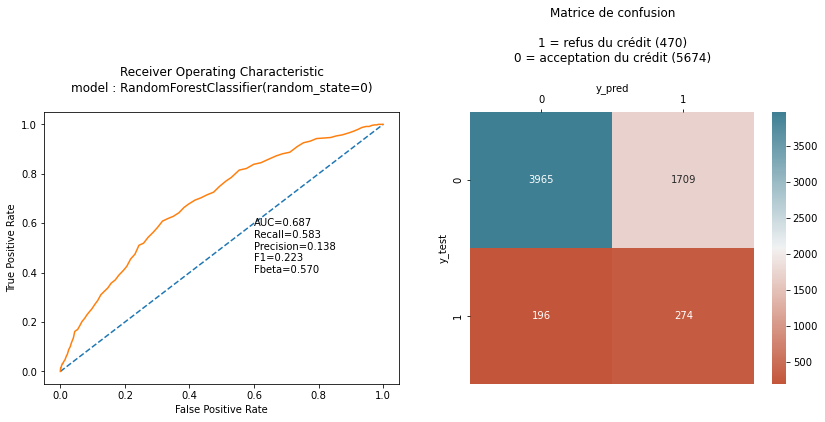

In [75]:
model = RandomForestClassifier(random_state=0)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.480

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       1.00      0.00      0.00       470

    accuracy                           0.92      6144
   macro avg       0.96      0.50      0.48      6144
weighted avg       0.93      0.92      0.89      6144

----------
f1-score : 0.004
fbeta-score : 0.002
precision : 1.000
recall : 0.002
auc : 0.675


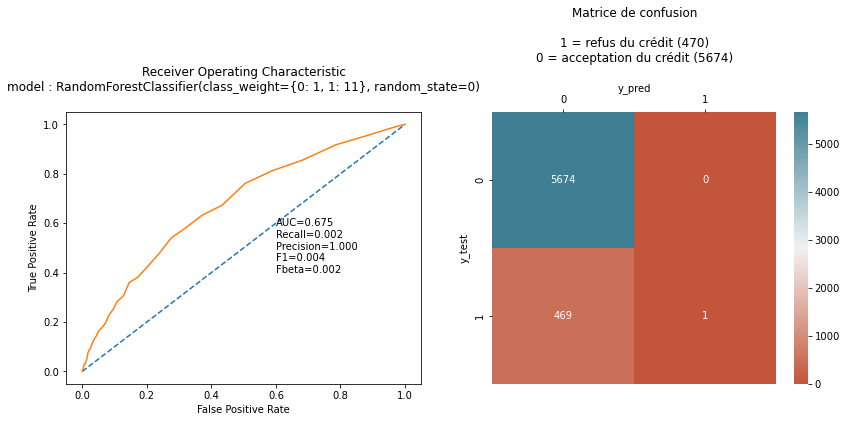

In [76]:
model = RandomForestClassifier(random_state=0, class_weight={
                               0: 1, 1: weight_positive})
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## LightGBM
 ### Jeu de données non équilibré

Seuil optimal de discrimination:0.110

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      5674
         1.0       0.33      0.01      0.02       470

    accuracy                           0.92      6144
   macro avg       0.63      0.50      0.49      6144
weighted avg       0.88      0.92      0.89      6144

----------
f1-score : 0.021
fbeta-score : 0.011
precision : 0.333
recall : 0.011
auc : 0.683


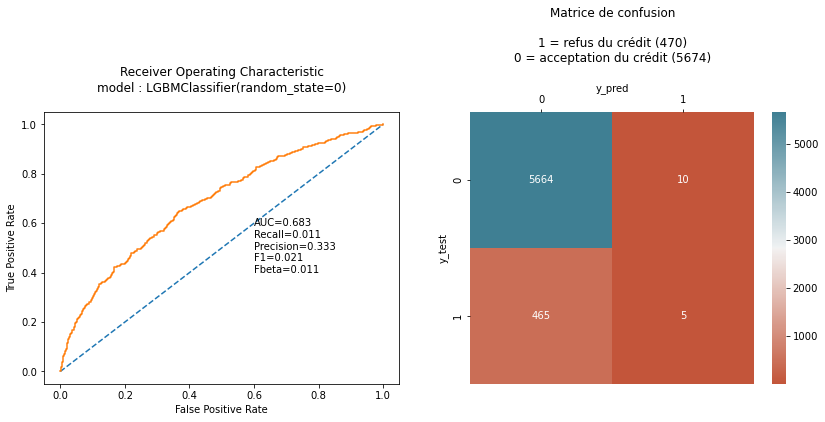

In [77]:
model = LGBMClassifier(random_state=0)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### Jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.487

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      5674
         1.0       0.14      0.58      0.22       470

    accuracy                           0.69      6144
   macro avg       0.54      0.64      0.51      6144
weighted avg       0.89      0.69      0.76      6144

----------
f1-score : 0.219
fbeta-score : 0.564
precision : 0.135
recall : 0.577
auc : 0.682


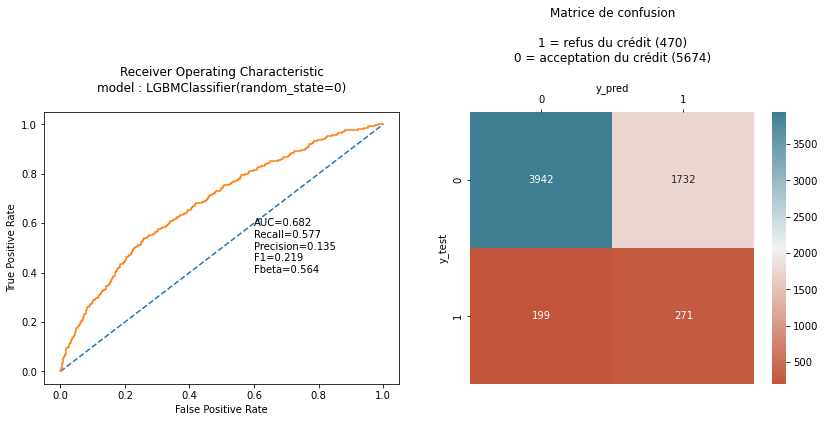

In [78]:
model = LGBMClassifier(random_state=0)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.482

              precision    recall  f1-score   support

         0.0       0.95      0.80      0.87      5674
         1.0       0.16      0.46      0.23       470

    accuracy                           0.77      6144
   macro avg       0.55      0.63      0.55      6144
weighted avg       0.89      0.77      0.82      6144

----------
f1-score : 0.234
fbeta-score : 0.452
precision : 0.157
recall : 0.457
auc : 0.684


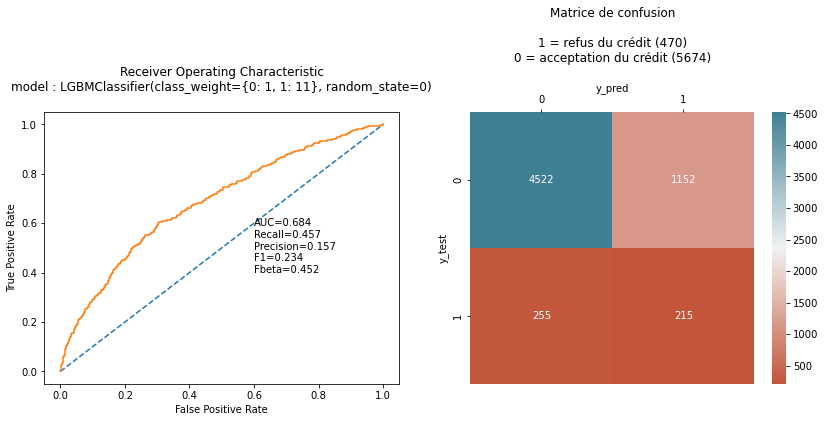

In [79]:
model = LGBMClassifier(random_state=0, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [80]:
resultats_choix_model.sort_values(by="Fbeta", ascending=False)


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
balanced_SMOTE_LogisticRegression(random_state=0),0.697315,0.589362,0.134205,0.218627,0.575892,0.539161,0.013985
balanced_SMOTE_RandomForestClassifier(random_state=0),0.686705,0.582979,0.138174,0.2234,0.570317,0.59,0.796231
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=0)",0.696831,0.578723,0.134988,0.218913,0.565894,0.488799,0.041447
balanced_SMOTE_LGBMClassifier(random_state=0),0.681847,0.576596,0.135297,0.219167,0.563911,0.486922,0.155273
"balanced_SMOTE_SGDClassifier(loss='modified_huber', random_state=0)",0.628941,0.470213,0.126286,0.199099,0.461544,0.332346,0.065539
"balanced_class_weight_LGBMClassifier(class_weight={0: 1, 1: 11}, random_state=0)",0.683866,0.457447,0.157279,0.234077,0.451504,0.482436,0.202111
not_balanced_LogisticRegression(random_state=0),0.698185,0.010638,0.454545,0.02079,0.01071,0.082049,0.041515
not_balanced_LGBMClassifier(random_state=0),0.682999,0.010638,0.333333,0.020619,0.01071,0.110133,0.258339
"balanced_class_weight_RandomForestClassifier(class_weight={0: 1, 1: 11}, random_state=0)",0.674903,0.002128,1.0,0.004246,0.002142,0.48,3.655494
not_balanced_RandomForestClassifier(random_state=0),0.666707,0.002128,0.2,0.004211,0.002142,0.47,4.508243


 Les deux meilleurs classifieurs sont la LogisticRegression et LGBMClassifier, à chaque fois avec des données équilibrées. Je vais donc chercher à optimiser ces deux classifieurs en testant les deux méthodes d'équilibrage des données

 # Optimisation des hyperparamètres
 ## SMOTE+undersampling
 ### LogisticRegression

In [81]:
# création du tableau qui va stocker les résultats des différentes optimisations
resultats_optimisation = pd.DataFrame(
    columns=['best_params', 'AUC', 'Recall', 'Precision', 'F1', 'Fbeta', 'seuil_opt', 'duree_calculs_s', 'duree_refit'])

# configuration de la fonction d'évaluation
fbeta_scorer = make_scorer(fbeta_score, beta=12)

# LogisticRegression : configuration des paramètres à tester
penalty = ['l1', 'l2', 'none']
C = uniform(loc=.0001, scale=100)
solver = ['sag', 'saga', 'lbfgs']

# LGBM : configuration des paramètres
max_depth = randint(low=5, high=15)
num_leaves = randint(low=2, high=30)  # doit être inférieur à 2*max_depth
num_iterations = randint(low=100, high=10000)
learning_rate = uniform(0.001, 10)
reg_alpha = uniform(0.001, 100)
reg_lambda = uniform(0.001, 100)
min_split_gain = uniform(0.001, 10)


In [82]:
# Fonction pour trouver les paramètres optimaux et stocker les résultats dans un tableau


def optimisation_param(model_opt, run, X_train, y_train, X_test, y_test, resultats):
    start = timeit.default_timer()
    # entrainement du modèle
    model_opt.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model_opt.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model_opt.predict(X_test)
    # extraction des probabilités
    y_proba = model_opt.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=12)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))

    # Stockage des résultats
    resultats.loc[run, "AUC"] = auc_score
    resultats.loc[run, "Recall"] = recall
    resultats.loc[run, 'Precision'] = precision
    resultats.loc[run, "F1"] = f1
    resultats.loc[run, "Fbeta"] = fbeta
    resultats.loc[run, "seuil_opt"] = best_thresh
    resultats.loc[run, "duree_calculs_s"] = elapsed
    resultats.loc[run, "duree_refit"] = float(model_opt.refit_time_)
    resultats.loc[run, 'best_params'] = str(model_opt.best_params_)

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristic\nmodel : {}\n".format(run))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
    plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
        nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats, model_opt


In [83]:


# params = {'logisticregression__penalty':penalty,
#         'logisticregression__C':C,
#         'logisticregression__solver':solver}


# # configuration modèle
# model = LogisticRegression(random_state=0)
# lr = make_pipeline(preprocessor, model)

# grid = GridSearchCV(lr, param_grid=params, scoring=fbeta_scorer, cv=5)
# resultats_optimisation, grid_opt = optimisation_param(grid, "OPT_LogRef_grid_smote", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)

In [84]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit


Seuil optimal de discrimination:0.539

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.80      5674
         1.0       0.13      0.59      0.22       470

    accuracy                           0.68      6144
   macro avg       0.54      0.64      0.51      6144
weighted avg       0.89      0.68      0.75      6144

----------
f1-score : 0.219
fbeta-score : 0.576
precision : 0.134
recall : 0.589
auc : 0.697


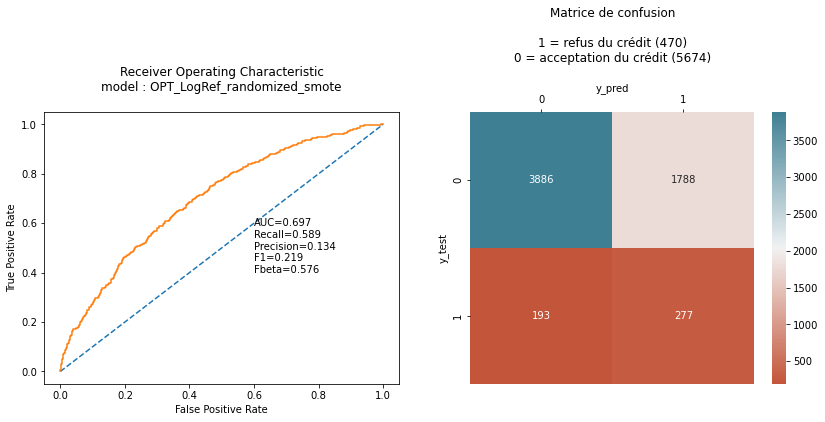

In [85]:
# test avec randomizedSearchCV
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=0)
lr = make_pipeline(preprocessor, model)

randomized_lr_smote = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=0)
resultats_optimisation, randomized_lr_smote_opt = optimisation_param(
    randomized_lr_smote, "OPT_LogRef_randomized_smote", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


In [86]:
pd.DataFrame(randomized_lr_smote.cv_results_).sort_values(by='rank_test_score')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028789,0.002714,0.003678,0.000853,54.88145,l2,sag,"{'logisticregression__C': 54.881450392732475, ...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
1,0.023598,0.002940,0.003603,0.001356,60.276438,l2,saga,"{'logisticregression__C': 60.27643760716439, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
2,0.028199,0.002227,0.003601,0.000490,38.438271,none,sag,"{'logisticregression__C': 38.43827072926999, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
3,0.020800,0.001720,0.003801,0.000749,96.366376,none,saga,"{'logisticregression__C': 96.36637605010293, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
4,0.026995,0.003402,0.003605,0.000802,79.172604,none,sag,"{'logisticregression__C': 79.17260380826646, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
5,0.022000,0.002829,0.003602,0.000489,39.27858,l2,saga,"{'logisticregression__C': 39.27857961008298, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
7,0.026999,0.003405,0.003801,0.000748,83.262085,none,sag,"{'logisticregression__C': 83.2620845547938, 'l...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
8,0.025807,0.002484,0.003199,0.000401,97.861934,l1,saga,"{'logisticregression__C': 97.8619342232764, 'l...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
9,0.028205,0.001468,0.003596,0.000487,46.148036,none,sag,"{'logisticregression__C': 46.14803622529319, '...",0.665443,0.645377,0.646144,0.665783,0.695477,0.663645,0.018227,1
6,0.005198,0.000402,0.000000,0.000000,33.739716,l1,sag,"{'logisticregression__C': 33.739716041726844, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [87]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.697309,0.589362,0.13414,0.21854,0.575884,0.539071,1.436117,0.026


 ### LGBM

Seuil optimal de discrimination:2.000

              precision    recall  f1-score   support

         0.0       0.89      0.43      0.58      5674
         1.0       0.05      0.38      0.09       470

    accuracy                           0.42      6144
   macro avg       0.47      0.40      0.34      6144
weighted avg       0.83      0.42      0.54      6144

----------
f1-score : 0.092
fbeta-score : 0.363
precision : 0.052
recall : 0.379
auc : 0.404


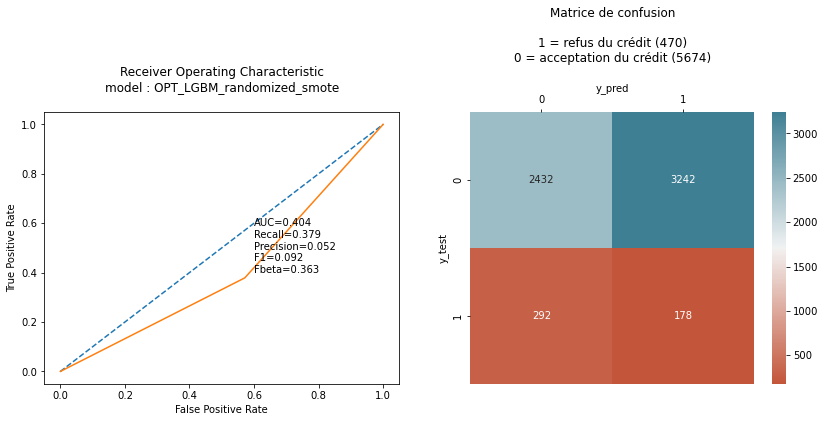

In [88]:
distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=0)
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_smote = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=0, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_smote_opt = optimisation_param(
    randomized_lgbm_smote, "OPT_LGBM_randomized_smote", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


In [89]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.697309,0.589362,0.13414,0.21854,0.575884,0.539071,1.436117,0.026
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 3.6834153984...,0.403673,0.378723,0.052047,0.091517,0.36301,2.0,47.115394,0.767007


 ## Class_weight
 ### LogisticRegression

Seuil optimal de discrimination:0.500

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      5674
         1.0       0.13      0.58      0.22       470

    accuracy                           0.68      6144
   macro avg       0.54      0.64      0.51      6144
weighted avg       0.89      0.68      0.76      6144

----------
f1-score : 0.219
fbeta-score : 0.566
precision : 0.135
recall : 0.579
auc : 0.697


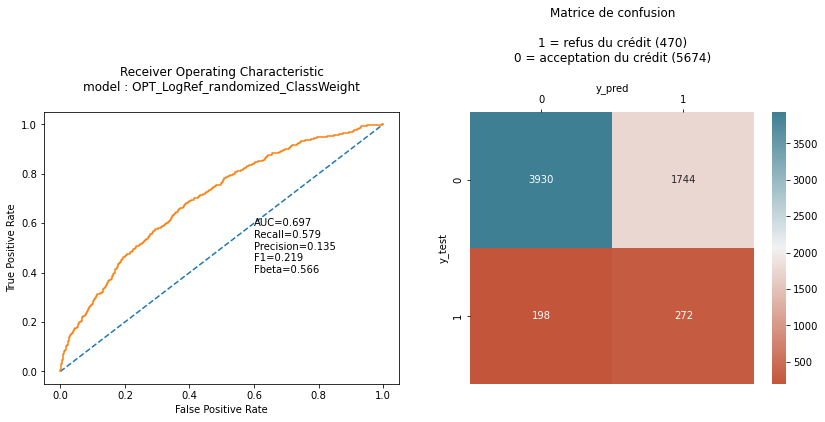

In [90]:
# configuration des paramètres à tester
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=0, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

randomized_lr_CW = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=0)
resultats_optimisation, randomized_lr_CW_opt = optimisation_param(
    randomized_lr_CW, "OPT_LogRef_randomized_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)


 ### LGBM

Seuil optimal de discrimination:1.000

              precision    recall  f1-score   support

         0.0       0.96      0.43      0.59      5674
         1.0       0.10      0.77      0.18       470

    accuracy                           0.45      6144
   macro avg       0.53      0.60      0.38      6144
weighted avg       0.89      0.45      0.56      6144

----------
f1-score : 0.178
fbeta-score : 0.740
precision : 0.101
recall : 0.774
auc : 0.601


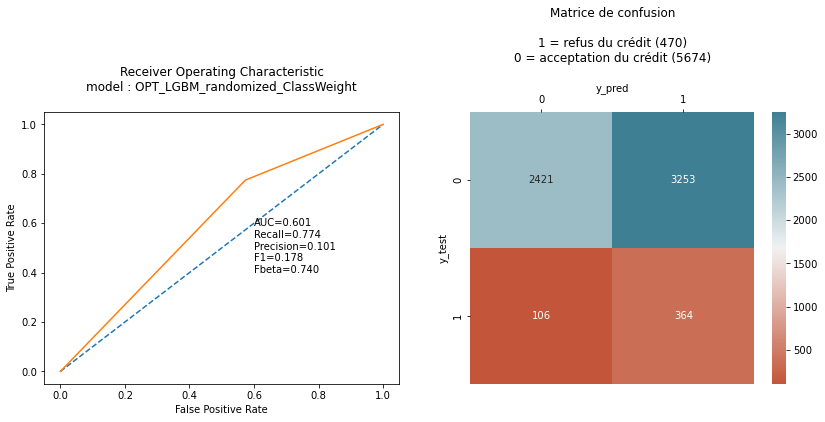

In [91]:
# configuration des paramètres
max_depth = randint(low=5, high=15)
num_leaves = randint(low=2, high=30)  # doit être inférieur à 2*max_depth
num_iterations = randint(low=100, high=10000)
learning_rate = uniform(0.001, 10)
reg_alpha = uniform(0.001, 100)
reg_lambda = uniform(0.001, 100)
min_split_gain = uniform(0.001, 10)

distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=0, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_CW = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=0, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_CW_opt = optimisation_param(
    randomized_lgbm_CW, "OPT_LGBM_randomized_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)


In [92]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.697309,0.589362,0.13414,0.21854,0.575884,0.539071,1.436117,0.026
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 3.6834153984...,0.403673,0.378723,0.052047,0.091517,0.36301,2.0,47.115394,0.767007
OPT_LogRef_randomized_ClassWeight,"{'logisticregression__C': 60.27643760716439, '...",0.696827,0.578723,0.134921,0.218825,0.565886,0.500168,10.07804,0.332002
OPT_LGBM_randomized_ClassWeight,{'lgbmclassifier__learning_rate': 4.6157936225...,0.600576,0.774468,0.100636,0.178126,0.740284,1.0,267.70624,5.235976
